In [3]:
import sqlalchemy
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import train_test_split

## MVP

In [4]:
# from sqlalchemy import create_engine
# engine = create_engine('postgresql:///walk')

In [5]:
df = pd.read_sql_table('manhattan_loc_d_ar_wea', 'postgresql:///walk')

In [6]:
def categorize_arrests(dataframe):
    cat_df = pd.DataFrame(dataframe, columns=['n_arrests'])
    cat_df.loc[cat_df['n_arrests'] > 0] = 1
    cat_df = cat_df.fillna(value=0).astype(int)
    output = cat_df.values.ravel()
    return output

In [5]:
last_ten = df.shape[0]*.9
eval_df = df.reset_index(drop=True).loc[last_ten:]
test_train_df = df.reset_index(drop=True).loc[:last_ten]
X_eval = eval_df.drop(columns=['n_arrests'])
y_eval = categorize_arrests(eval_df['n_arrests'])

In [6]:
X = test_train_df.drop(columns=['n_arrests'])
y = categorize_arrests(test_train_df['n_arrests'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [219]:
df.head()

,latitude,longitude,date,n_arrests,ap_t_high100,ap_t_low100,cloud,humidity,icon,moon_phase,precip_inten_max10000,precip_proba100,precipType,pressure,sunriseTime,sunsetTime,uvIndex,wind_gust100,precip_accum100,ozone10
0,40.683,-74.023,2018-01-02,NaN,1943,1085,5,57,clear-day,54,0,0,None,1029,1514895663,1514929247,2,1259,NaN,NaN
1,40.684,-74.012,2018-01-02,NaN,1943,1085,5,57,clear-day,54,0,0,None,1029,1514895663,1514929247,2,1259,NaN,NaN
2,40.684,-74.024,2018-01-02,NaN,1943,1085,5,57,clear-day,54,0,0,None,1029,1514895663,1514929247,2,1259,NaN,NaN
3,40.685,-74.022,2018-01-02,NaN,1943,1085,5,57,clear-day,54,0,0,None,1029,1514895663,1514929247,2,1259,NaN,NaN
4,40.685,-74.023,2018-01-02,NaN,1943,1085,5,57,clear-day,54,0,0,None,1029,1514895663,1514929247,2,1259,NaN,NaN


In [93]:
class DateTransformer():
    """Transforms df so that there are columns representing the features of the date.
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = pd.Series([pd.to_datetime(x, format="%Y-%m-%d") for x in X['date']])
        X_transf = pd.DataFrame()
        X_transf['year'] = [x.year for x in X]
        X_transf['month'] = [x.month for x in X]
        X_transf['day'] = [x.day for x in X]
        X_transf['weekday'] = [x.weekday() for x in X]
        return np.array(X_transf)

In [8]:
class TimeOfDayTransformer():    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        structtime = [time.gmtime(x) for x in X.values]
        X_transf = np.array([(x.tm_hour*60 + x.tm_min) for x in structtime]).reshape(-1, 1)
        return X_transf

In [9]:
class StringTransformer():    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
#         X_trans = np.array(X.astype(str)).reshape(-1, 1)
#         print(X_trans)
        return np.array(X.astype(str)).reshape(-1, 2)

In [116]:
impute_zero_features = ['precip_accum100']
impute_zero_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

# impute_mean_features = ['ozone10']
# impute_mean_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer()),
#     ('scaler', StandardScaler())
# ])

date_transformer = Pipeline(steps=[
    ('date_expansion', DateTransformer()),
    ('ohe', OneHotEncoder(categories='auto'))
])

# categorical_features = ['icon', 'precipType']
# categorical_transformer = Pipeline(steps=[
#     ('string', StringTransformer()),
#     ('ohe', OneHotEncoder(categories='auto'))
# ])

time_of_day_features = ['sunriseTime', 'sunsetTime']
time_of_day_transformer = Pipeline(steps=[
    ('time', TimeOfDayTransformer()),
    ('scaler', StandardScaler())
])

other_numeric_features = ['latitude', 'longitude', 'ap_t_high100',
                         'ap_t_low100', 'cloud', 'humidity',
                          'precip_inten_max10000', 'precip_proba100', 
                          'wind_gust100',] 
                        # removed: 'moon_phase','pressure','uvIndex', 

preprocessor = ColumnTransformer( transformers=[
    ('missing0', impute_zero_transformer, impute_zero_features),
#     ('missing_mean', impute_mean_transformer, impute_mean_features),
    ('date', date_transformer, ['date']),
#     ('categoricals', categorical_transformer, categorical_features),
    ('sunrise', time_of_day_transformer, ['sunriseTime']),
    ('sunset', time_of_day_transformer, ['sunsetTime']),
    ('ss', StandardScaler(), other_numeric_features)
    ], remainder='passthrough')




In [186]:
rfc = RandomForestClassifier(n_estimators=10, max_depth=15, random_state=5,
                            class_weight='balanced')
# sm = SMOTE(random_state=20)

In [187]:
pipe = Pipeline([
    ('preprocess', preprocessor),
#     ('smote', sm),
    ('model', rfc)
])

In [188]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 09:42:57


In [189]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('missing0',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=0,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                    

In [190]:
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 09:48:34


In [191]:
train_preds = pipe.predict(X_train)
train_proba = pipe.predict_proba(X_train)

In [192]:
def print_scores(true, pred, pred_proba):
    lloss = log_loss(true, pred_proba)
    cf = confusion_matrix(true, pred)
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    print(f"log loss: {lloss}\n\nconfusion matrix:\n{cf}\naccuracy: {acc}\nF1 score: {f1}")

In [193]:
print_scores(y_train, train_preds, train_proba)

log loss: 0.6554919498912687

confusion matrix:
[[1414645 1018289]
 [  14579   29316]]
accuracy: 0.5829877637899104
F1 score: 0.05371690334402199


In [194]:
test_preds = pipe.predict(X_test)
test_proba = pipe.predict_proba(X_test)

In [195]:
print_scores(y_test, test_preds, test_proba)

log loss: 0.6561418306816723

confusion matrix:
[[352946 255240]
 [  4175   6847]]
accuracy: 0.5810535393599566
F1 score: 0.050141152433643706


In [127]:
from matplotlib import pyplot as plt
%matplotlib inline

In [196]:
test_proba[:20]

array([[0.46265232, 0.53734768],
       [0.5607255 , 0.4392745 ],
       [0.34505491, 0.65494509],
       [0.46966621, 0.53033379],
       [0.65626304, 0.34373696],
       [0.81226988, 0.18773012],
       [0.61327864, 0.38672136],
       [0.50286469, 0.49713531],
       [0.42348965, 0.57651035],
       [0.74771592, 0.25228408],
       [0.58251917, 0.41748083],
       [0.48496381, 0.51503619],
       [0.53599925, 0.46400075],
       [0.59582504, 0.40417496],
       [0.46988085, 0.53011915],
       [0.46166842, 0.53833158],
       [0.43956522, 0.56043478],
       [0.49838447, 0.50161553],
       [0.53390722, 0.46609278],
       [0.56306723, 0.43693277]])

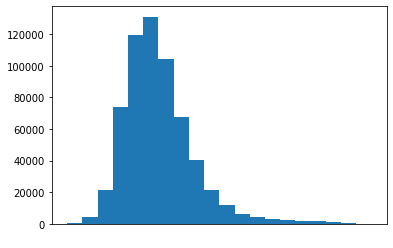

In [197]:
fig, ax = plt.subplots()
ax.hist(test_proba[:,0], bins=20)
ax.tick_params(axis='x', colors='white')

In [201]:
from sklearn.metrics import roc_curve

In [208]:
fpr, tpr, thrsholds = roc_curve(y_test, test_proba[:, 1])

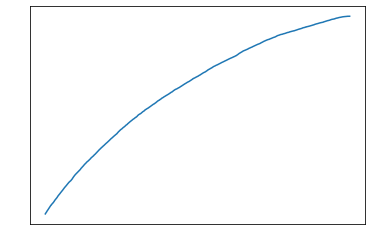

In [212]:
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white');

In [218]:
pipe.named_steps['preprocess']

ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('missing0',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=0,
                                                                missing_values=nan,
                                                                strategy='constant',
                                                                verbose=0)),
                                                 ('scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                

<BarContainer object of 76 artists>

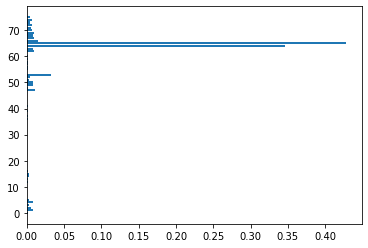

In [213]:
plt.barh(range(rfc.n_features_), rfc.feature_importances_)

In [171]:
for estimator in rfc.estimators_:
    print (estimator.tree_.node_count)

1
1
1
1
1
1
1
1
1
1


In [198]:
from sklearn.linear_model import LogisticRegression

In [199]:
lr = LogisticRegression(random_state=0, solver='lbfgs')

In [200]:
lr_pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', rfc)
])

In [ ]:
lr_

In [35]:
import pickle

In [77]:
output_file = open("walk1.pickle", "wb")
pickle.dump(rfc, output_file)
output_file.close()

In [80]:
from joblib import dump, load

In [81]:
output_file = open("preprocessor.joblib", "wb")
dump(preprocessor, output_file)
output_file.close()

In [51]:
import pickle
import pandas as pd
import joblib

In [95]:
model_file = open('walk1.pickle', "rb")
loaded_model = pickle.load(model_file)
model_file.close()

In [96]:
preprocessor_file = open('preprocessor.joblib', 'rb')
loaded_preprocessor = joblib.load(preprocessor_file)
preprocessor_file.close()

In [7]:
# path, warnings = get_route(secret_loc_goog, start_lat_long, end_lat_long)

pts = pd.read_csv('practice_route_pts.csv') # pts = get_points_near_path(path, )
pts = pts.drop(columns=['geometry', 'on_path'])

In [9]:
df.columns

Index(['latitude', 'longitude', 'date', 'n_arrests', 'ap_t_high100',
       'ap_t_low100', 'cloud', 'humidity', 'precip_inten_max10000',
       'precip_proba100', 'sunriseTime', 'sunsetTime', 'wind_gust100',
       'precip_accum100'],
      dtype='object')

In [10]:
day_weather = pd.DataFrame(df.loc[0, 'date':'precip_accum100']).T

In [11]:
day_weather.head()

,date,n_arrests,ap_t_high100,ap_t_low100,cloud,humidity,precip_inten_max10000,precip_proba100,sunriseTime,sunsetTime,wind_gust100,precip_accum100
0,2018-01-02,NaN,1943,1085,5,57,0,0,1514895663,1514929247,1259,NaN


In [12]:
day_weather = day_weather.drop(columns=['n_arrests'])
day_weather.columns

Index(['date', 'ap_t_high100', 'ap_t_low100', 'cloud', 'humidity',
       'precip_inten_max10000', 'precip_proba100', 'sunriseTime', 'sunsetTime',
       'wind_gust100', 'precip_accum100'],
      dtype='object')

In [13]:
for col in day_weather.columns:

    pts[col] = day_weather[col].values[0]

In [14]:
pts.head()

,latitude,longitude,date,ap_t_high100,ap_t_low100,cloud,humidity,precip_inten_max10000,precip_proba100,sunriseTime,sunsetTime,wind_gust100,precip_accum100
0,40.722,-73.993,2018-01-02,1943,1085,5,57,0,0,1514895663,1514929247,1259,NaN
1,40.722,-73.992,2018-01-02,1943,1085,5,57,0,0,1514895663,1514929247,1259,NaN
2,40.722,-73.991,2018-01-02,1943,1085,5,57,0,0,1514895663,1514929247,1259,NaN
3,40.722,-73.990,2018-01-02,1943,1085,5,57,0,0,1514895663,1514929247,1259,NaN
4,40.722,-73.989,2018-01-02,1943,1085,5,57,0,0,1514895663,1514929247,1259,NaN


In [15]:
pts.columns

Index(['latitude', 'longitude', 'date', 'ap_t_high100', 'ap_t_low100', 'cloud',
       'humidity', 'precip_inten_max10000', 'precip_proba100', 'sunriseTime',
       'sunsetTime', 'wind_gust100', 'precip_accum100'],
      dtype='object')

In [104]:
inputs = loaded_preprocessor.transform(pts)

In [105]:
preds = loaded_model.predict_proba(inputs)

In [148]:
arr_proba = [x[1] for x in preds]

In [152]:
sum(arr_proba)/24

0.17083333333333336

In [153]:
arr_proba

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.1,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.1,
 0.1,
 0.0,
 0.5,
 0.1,
 0.0,
 0.1,
 0.0,
 0.9,
 0.0,
 0.0,
 0.1,
 0.0,
 0.3,
 0.0,
 0.1,
 0.2,
 0.2,
 0.0,
 0.2,
 0.3,
 0.0]

In [114]:
for estimator in loaded_model.estimators_:
    print (estimator.tree_.node_count)

820477
820449
821323
816221
817471
822543
824973
822973
824789
829049


In [115]:
loaded_model.feature_importances_

array([1.04267456e-04, 1.13306095e-03, 1.94367735e-04, 3.15435432e-04,
       2.78068793e-04, 1.92479290e-04, 1.32624706e-04, 1.57298549e-04,
       1.37649603e-04, 1.03071565e-04, 9.50281788e-05, 1.07603126e-04,
       1.52797350e-04, 1.46776035e-04, 9.47345782e-05, 1.86469708e-04,
       1.35097065e-04, 1.47082817e-04, 7.06907557e-05, 1.13847645e-04,
       1.04882674e-04, 9.72572029e-05, 1.16873009e-04, 1.12705466e-04,
       1.15632194e-04, 1.18698393e-04, 8.99298058e-05, 1.14451324e-04,
       9.82026912e-05, 1.31693543e-04, 1.59635443e-04, 1.00359028e-04,
       1.19401169e-04, 9.09422634e-05, 1.33177737e-04, 1.32779773e-04,
       1.69433988e-04, 1.21309143e-04, 9.50059831e-05, 1.58526157e-04,
       2.01113213e-04, 1.23441776e-04, 1.50524618e-04, 1.20048833e-04,
       1.00015023e-04, 1.09615753e-04, 7.93741213e-05, 8.23310152e-04,
       3.48761832e-04, 4.65851298e-04, 5.00033121e-04, 3.24996302e-04,
       3.10827997e-04, 1.91908813e-03, 1.92089183e-04, 1.56727035e-04,
      

# Minimum MVP

In [51]:
def predict_arrest_proba(start, end):
    return y.mean()

In [61]:
round(predict_arrest_proba("",""), 3)

0.018

In [63]:
round(y_eval.mean(), 3)

0.016

# 2nd MVP

In [2]:
import pandas as pd

In [3]:
lat_long_arrests_df = pd.read_sql_query("""
                    SELECT latitude, 
                            longitude, 
                            COUNT(n_arrests) as arrest_days 
                    FROM manhattan_loc_d_ar_wea 
                    GROUP BY latitude, longitude;"""
                                    , 'postgresql:///walk')

final_date = pd.read_sql_query("""SELECT date
                                    FROM manhattan_loc_d_ar_wea
                                    ORDER BY date DESC
                                    LIMIT 1""", 'postgresql:///walk')

start_date = pd.read_sql_query("""SELECT date
                                    FROM manhattan_loc_d_ar_wea
                                    ORDER BY date ASC
                                    LIMIT 1""", 'postgresql:///walk')

total_days = (final_date.iloc[0,0] - start_date.iloc[0,0]).days

# set probability for each location based on the rate of days with arrests in the data set
lat_long_arrest_df['probability'] = lat_long_arrest_df['arrest_days'] / total_days

# create latlong column as unique identifier to join on
pts_df['latlong'] = (round(pts_df['latitude'], 3).astype(str) 
                     + round(pts_df['longitude'], 3).astype(str))
lat_long_arrest_df['latlong'] = (round(lat_long_arrest_df['latitude'], 3).astype(str) 
                              + round(lat_long_arrest_df['longitude'], 3).astype(str))

# clean lat_long_est_df
lat_long_arrest_df = lat_long_arrest_df.drop(columns=['latitude', 'longitude'])

# left join data tables on 'latlong', adding the probability of arrest occuring to each latlong in pts_df
pts_proba_df = pts_df.set_index('latlong').join(lat_long_arrest_df.set_index('latlong'))
